# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

## Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Model creation

In [3]:
from tensorflow.keras import layers

In [4]:
def teacher_initial():
# Build CNN teacher.
  cnn_model = tf.keras.Sequential()
  cnn_model.add(layers.Conv2D(32, 3, (1, 1), activation='relu', input_shape=(28, 28, 1)))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=1))
  cnn_model.add(layers.Conv2D(64, 3, (1, 1), activation='relu'))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=2))
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(128, activation='relu'))
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(10))
  return cnn_model


# your code start from here for stpe 2


def student_initial():
# Build fully connected student.
  fc_model = tf.keras.Sequential()
  fc_model.add(tf.keras.Input(shape=(28, 28, 1)))
  fc_model.add(layers.Flatten())
  fc_model.add(layers.Dense(784, activation='relu'))
  fc_model.add(layers.Dense(784, activation='relu'))
  fc_model.add(layers.Dense(10))
# your code start from here for step 2
  return fc_model



In [5]:
teacher_model = teacher_initial()
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [6]:
student_model = student_initial()
student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


## Teacher loss function

In [7]:
from tensorflow.python.ops.math_ops import truediv
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))
  #bce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  #cross_entropy_loss_value = bce(labels, subclass_logits)

  return cross_entropy_loss_value

## Student loss function

In [8]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  #teacher_logits = cnn_model(images, training=True)
  
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3


  hard_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))


  return (ALPHA * distillation_loss_value + (1- ALPHA) * hard_loss_value)

## Train and evaluation

In [9]:
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


## Training teacher

In [10]:
train_and_evaluate(teacher_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.02%
Epoch 2: Class_accuracy: 98.67%
Epoch 3: Class_accuracy: 98.83%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 99.02%
Epoch 6: Class_accuracy: 99.11%
Epoch 7: Class_accuracy: 99.23%
Epoch 8: Class_accuracy: 99.14%
Epoch 9: Class_accuracy: 99.18%
Epoch 10: Class_accuracy: 99.35%
Epoch 11: Class_accuracy: 99.28%
Epoch 12: Class_accuracy: 99.28%


## Distill to student

In [11]:
train_and_evaluate(student_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.83%
Epoch 2: Class_accuracy: 97.82%
Epoch 3: Class_accuracy: 98.20%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.63%
Epoch 6: Class_accuracy: 98.69%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.78%
Epoch 9: Class_accuracy: 98.86%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.81%


## Hyperparameter tunning

In [ ]:
def student_loss_changeT(images, labels, T, alpha=0.5):
  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, T)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return (alpha * distillation_loss_value + (1- alpha) * cross_entropy_loss_value)

def student_test_acc(model, compute_loss_fn, T, alpha=0.5):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels, T, alpha=0.5)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

1 Temperature done
2 Temperature done
4 Temperature done
16 Temperature done
32 Temperature done
64 Temperature done
Best test accuracy for each T is [<tf.Tensor: shape=(), dtype=float32, numpy=98.27>, <tf.Tensor: shape=(), dtype=float32, numpy=98.47>, <tf.Tensor: shape=(), dtype=float32, numpy=98.86>, <tf.Tensor: shape=(), dtype=float32, numpy=98.85>, <tf.Tensor: shape=(), dtype=float32, numpy=98.85>, <tf.Tensor: shape=(), dtype=float32, numpy=98.79>]


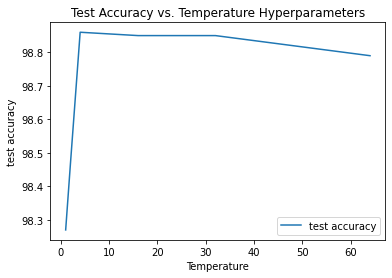

In [ ]:
T = [1, 2, 4, 16, 32, 64]
test_accuracy_list = []
for temp in T:
  student_model = student_initial()
  test_accuracy = student_test_acc(student_model, student_loss_changeT, T = temp, alpha=0.5)
  print(temp,'Temperature done')
  test_accuracy_list.append(test_accuracy[-1])
print('Best test accuracy for each T is',test_accuracy_list)
plt.plot(T, test_accuracy_list, label='test accuracy')
plt.xlabel("Temperature")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs. Temperature Hyperparameters")
plt.legend()
plt.show()

In [ ]:
test_accuracy_list

[<tf.Tensor: shape=(), dtype=float32, numpy=98.27>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.47>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.86>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.85>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.85>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.79>]

In [ ]:
def student_loss_changealpha(images, labels,  alpha):
  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, 4)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return (alpha * distillation_loss_value + (1- alpha) * cross_entropy_loss_value)

def student_test_acc_change(model, compute_loss_fn, T, alpha=0.5):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels, alpha)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

0.1 Alpha done
0.2 Alpha done
0.3 Alpha done
0.4 Alpha done
0.5 Alpha done
0.6 Alpha done
0.7 Alpha done
0.8 Alpha done
0.9 Alpha done
Final test accuracy for each alpha is [<tf.Tensor: shape=(), dtype=float32, numpy=98.74>, <tf.Tensor: shape=(), dtype=float32, numpy=98.74>, <tf.Tensor: shape=(), dtype=float32, numpy=98.81>, <tf.Tensor: shape=(), dtype=float32, numpy=98.72>, <tf.Tensor: shape=(), dtype=float32, numpy=98.77>, <tf.Tensor: shape=(), dtype=float32, numpy=98.84>, <tf.Tensor: shape=(), dtype=float32, numpy=98.799995>, <tf.Tensor: shape=(), dtype=float32, numpy=98.77>, <tf.Tensor: shape=(), dtype=float32, numpy=98.83>]


ValueError: ignored

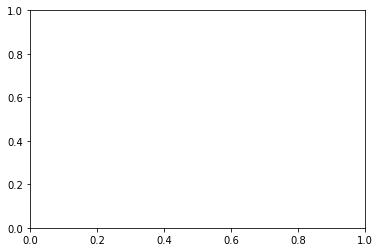

In [ ]:
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_accuracy_list = []
for a in alpha:
  student_model = student_initial()
  test_accuracy = student_test_acc_change(student_model, student_loss_changealpha, T = 4, alpha=a)
  print(a,'Alpha done')
  test_accuracy_list.append(test_accuracy[-1])
print('Final test accuracy for each alpha is',test_accuracy_list)
plt.plot(a, test_accuracy_list, label='test accuracy')
plt.xlabel("Alpha")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs. Task Balance Hyperparameters")
plt.legend()
plt.show()

Final test accuracy for each alpha is [<tf.Tensor: shape=(), dtype=float32, numpy=98.74>, <tf.Tensor: shape=(), dtype=float32, numpy=98.74>, <tf.Tensor: shape=(), dtype=float32, numpy=98.81>, <tf.Tensor: shape=(), dtype=float32, numpy=98.72>, <tf.Tensor: shape=(), dtype=float32, numpy=98.77>, <tf.Tensor: shape=(), dtype=float32, numpy=98.84>, <tf.Tensor: shape=(), dtype=float32, numpy=98.799995>, <tf.Tensor: shape=(), dtype=float32, numpy=98.77>, <tf.Tensor: shape=(), dtype=float32, numpy=98.83>]


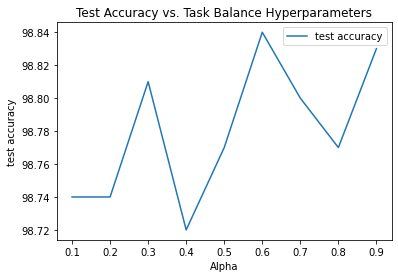

In [ ]:
print('Final test accuracy for each alpha is',test_accuracy_list)
plt.plot(alpha, test_accuracy_list, label='test accuracy')
plt.xlabel("Alpha")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs. Task Balance Hyperparameters")
plt.legend()
plt.show()

In [ ]:
test_accuracy_list

[<tf.Tensor: shape=(), dtype=float32, numpy=98.74>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.74>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.81>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.799995>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.83>]

## Train student from scratch

In [ ]:
student_model = student_initial()
# your code start from here for step 7


def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits) 
  
  return cross_entropy_loss


train_and_evaluate(student_model, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 97.02%
Epoch 2: Class_accuracy: 97.32%
Epoch 3: Class_accuracy: 97.84%
Epoch 4: Class_accuracy: 97.89%
Epoch 5: Class_accuracy: 97.81%
Epoch 6: Class_accuracy: 98.07%
Epoch 7: Class_accuracy: 98.04%
Epoch 8: Class_accuracy: 98.27%
Epoch 9: Class_accuracy: 98.06%
Epoch 10: Class_accuracy: 98.21%
Epoch 11: Class_accuracy: 97.97%
Epoch 12: Class_accuracy: 97.98%


## Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

In [ ]:
# your code start from here for step 8
cnnflops = get_flops(teacher_model)
fcflops = get_flops(student_model)
print('flops for teacher teacher model is',cnnflops)
print('flops for student student model is',fcflops)

flops for teacher teacher model is 22042058
flops for student student model is 2475882


In [ ]:
teacher_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 7744)              0         
                                                                 
 dropout_4 (Dropout)         (None, 7744)             

In [ ]:
student_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 dense_81 (Dense)            (None, 784)               615440    
                                                                 
 dense_82 (Dense)            (None, 784)               615440    
                                                                 
 dense_83 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


## Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12

def ta_initial():
# Build CNN teacher.
  ta_model = tf.keras.Sequential()
  ta_model.add(layers.Conv2D(32, 3, (1, 1), activation='relu', input_shape=(28, 28, 1)))
  ta_model.add(layers.MaxPooling2D((2, 2), strides=1))
  ta_model.add(layers.Flatten())
  ta_model.add(layers.Dropout(0.5))
  ta_model.add(layers.Dense(128, activation='relu'))
  ta_model.add(layers.Dropout(0.5))
  ta_model.add(layers.Dense(10))
  return ta_model

In [ ]:
ta_model = ta_initial()

In [ ]:
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

In [ ]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))
  #bce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  #cross_entropy_loss_value = bce(labels, subclass_logits)

  return cross_entropy_loss_value

In [ ]:
train_and_evaluate(teacher_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 99.24%
Epoch 2: Class_accuracy: 99.23%
Epoch 3: Class_accuracy: 99.28%
Epoch 4: Class_accuracy: 99.34%
Epoch 5: Class_accuracy: 99.36%
Epoch 6: Class_accuracy: 99.29%
Epoch 7: Class_accuracy: 99.29%
Epoch 8: Class_accuracy: 99.37%
Epoch 9: Class_accuracy: 99.20%
Epoch 10: Class_accuracy: 99.31%
Epoch 11: Class_accuracy: 99.27%
Epoch 12: Class_accuracy: 99.40%


In [ ]:
ALPHA = 0.6 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

In [ ]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):

  student_subclass_logits = ta_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
  hard_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))


  return (ALPHA * distillation_loss_value + (1- ALPHA) * hard_loss_value)

In [ ]:
train_and_evaluate(ta_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.43%
Epoch 2: Class_accuracy: 97.91%
Epoch 3: Class_accuracy: 98.10%
Epoch 4: Class_accuracy: 98.36%
Epoch 5: Class_accuracy: 98.41%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.50%
Epoch 8: Class_accuracy: 98.51%
Epoch 9: Class_accuracy: 98.74%
Epoch 10: Class_accuracy: 98.75%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.81%


In [ ]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):

  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
  hard_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))


  return (ALPHA * distillation_loss_value + (1- ALPHA) * hard_loss_value)

In [ ]:
student_model = student_initial()

In [ ]:
train_and_evaluate(student_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.25%
Epoch 2: Class_accuracy: 97.53%
Epoch 3: Class_accuracy: 98.02%
Epoch 4: Class_accuracy: 98.19%
Epoch 5: Class_accuracy: 98.21%
Epoch 6: Class_accuracy: 98.30%
Epoch 7: Class_accuracy: 98.41%
Epoch 8: Class_accuracy: 98.44%
Epoch 9: Class_accuracy: 98.49%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.51%
Epoch 12: Class_accuracy: 98.59%


# (Optional) XAI method to explain models

In [ ]:
import numpy as np

In [ ]:
# your code start from here for step 13
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:
images = tuple(zip(mnist_train))

In [ ]:
sample_img = images[0][0][0][0]

In [ ]:
sample_img.shape

TensorShape([28, 28, 1])

In [ ]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

sample_img_test = to_rgb(sample_img)

In [ ]:
student_model.predict(sample_img.numpy().reshape(1, 28, 28, 1))

1/1 [==============================] - 0s 52ms/step


array([[ 26.878738 , -11.611966 ,  -4.6489873,  -9.595115 ,  -8.864883 ,
         -7.989394 ,   5.979331 ,  -8.822833 ,  -3.14196  ,   4.679235 ]],
      dtype=float32)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(sample_img_test, student_model.predict(sample_img.numpy().reshape(1, 28, 28, 1)),top_labels=3, hide_color=0, num_samples=1000)

1/1 [==============================] - 0s 21ms/step


RuntimeError: ignored